<a href="https://colab.research.google.com/github/ricardofradeb/previsao_vendas/blob/main/previsao_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Previsão de vendas de um produto específico

Realização da importação das bibliotecas:

*   pandas - para análise e manipulação dos dados
*   seaborn - para plot de distribuição (histograma)
*   plotly - usado para plotar graficos de pizza das principais váriveis


In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px

Leitura do dataset, que pode ser encontrado em [kaggle supplement sales](https://www.kaggle.com/sureshmecad/supplement-sales-prediction) e visualização das primeiras linhas.

**Nossa variável de saída é a coluna** ```#Order``` **que representa o número de pedidos, dadas as condições apresentadas nas demais colunas**


In [16]:
data = pd.read_csv("/TRAIN.csv")
data.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


Agora veremos algumas características necessárias para saber que tipo de dataset estamos trabalhando.
Extraindo informações a respeito do tipo de dados em cada coluna, e contagem de valores, nulos e não nulos.

As principais colunas (entradas) são ```Store_Type```, ```Location_Type```, ```Holiday```, ```Discount```, enquanto ```#Order``` será a saída do nosso sitema.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


Explicitando agora o total de valores nulos, que representam valores faltantes, podemos notar que o dataset não os apresenta.

In [18]:
data.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

Agora vamos explicitar as pricipais informações do dataset, como a média e o desvio padrão.

In [19]:
data.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


A seguir daremos inicio a tratativa de outliers.

Analisamos a disitibuição, por meio de um histograma e estimativa de densidade kernel, assumindo com base nessa análise podemos aplicar o método Z-score para identificar  e remover os outliners. 

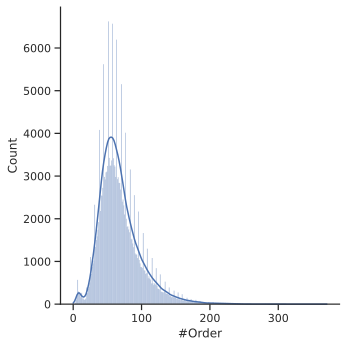

In [20]:
# sns.displot(data['#Order'])
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="ticks", color_codes=True)
sns.displot(data=data, x="#Order", kde=True)

Os limites inferior e superior são definidos com o valor de 3 vezes o desvio padrão à esquerda e direita da média.

Avaliando nosso problema é perceptivel que o menor valor possivel para número de pedidos é 0, então fazemos este reajuste.

In [21]:
upper_limit = data['#Order'].mean() + 3*data['#Order'].std()
lower_limit = data['#Order'].mean() - 3*data['#Order'].std()
lower_limit = 0 if lower_limit < 0 else lower_limit

print("Highest allowed", upper_limit)
print("Lowest allowed", data['#Order'].mean() - 3*data['#Order'].std(), "->" , lower_limit)

Highest allowed 159.6079356258474
Lowest allowed -23.19655195801262 -> 0


Apresentamos os outliers:

In [22]:
outliers = data[(data['#Order'] > upper_limit)]
outliers

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
306,T1000307,176,S4,L2,R3,2018-01-01,1,Yes,180,126633.00
493,T1000494,337,S4,L2,R1,2018-01-02,0,Yes,189,132699.00
594,T1000595,312,S4,L2,R1,2018-01-02,0,Yes,167,113439.00
623,T1000624,175,S4,L2,R1,2018-01-02,0,Yes,181,121248.00
786,T1000787,337,S4,L2,R1,2018-01-03,0,Yes,189,142662.00
...,...,...,...,...,...,...,...,...,...,...
187689,T1187690,315,S4,L2,R1,2019-05-30,0,No,173,99027.00
187794,T1187795,175,S4,L2,R1,2019-05-30,0,No,180,104406.00
188036,T1188037,315,S4,L2,R1,2019-05-31,1,Yes,168,96056.19
188241,T1188242,175,S4,L2,R1,2019-05-31,1,No,179,103361.94


Apresentamos tambés informações relevantes dos outliers:

In [23]:
outliers.describe()

,Store_id,Holiday,#Order,Sales
count,2664.000000,2664.000000,2664.000000,2664.000000
mean,210.603979,0.075450,186.501877,108098.625349
std,91.372366,0.264166,26.922456,20326.119677
min,2.000000,0.000000,160.000000,65689.080000
25%,146.000000,0.000000,168.000000,93855.750000
50%,175.000000,0.000000,178.000000,104148.000000
75%,312.000000,0.000000,198.000000,117324.000000
max,357.000000,1.000000,371.000000,247215.000000


Por fim removemos os outliers obtendo trimmed_data e mais uma vez verificamos sua distribuição.

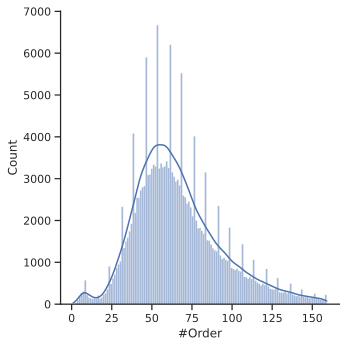

In [24]:
trimmed_data = data[(data['#Order'] < upper_limit) & (data['#Order'] > lower_limit)]
trimmed_data.describe()
%config InlineBackend.figure_format = 'svg'
sns.displot(data=trimmed_data, x="#Order", kde=True)

Distribuição do número de pedidos de acordo com o tipo de loja:

*   S1
*   S2
*   S3
*   S4



In [25]:
pie = data["Store_Type"].value_counts()
store = pie.index
orders = pie.values

fig = px.pie(data, values=orders, names=store)
fig.show()

Número de pedido recebidos de acordo com a localização

L1
L2
L3
L4
L5

In [26]:
pie2 = data["Location_Type"].value_counts()
location = pie2.index
orders = pie2.values

fig = px.pie(data, values=orders, names=location)
fig.show()


A distribuição de acordo com a existencia de descontos.

De acordo com o gráfico, a maioria das compras é realizada com ausência de desconto.

In [27]:
pie3 = data["Discount"].value_counts()
discount = pie3.index
orders = pie3.values

fig = px.pie(data, values=orders, names=discount)
fig.show()

A distribuição das compras entre dias úteis e feriados.

De acordo com o gráfico, a maior quantidade de pedidos encontra-se nos dias úteis.

In [28]:
pie4 = data["Holiday"].value_counts()
holiday = pie4.index
orders = pie4.values

fig = px.pie(data, values=orders, names=holiday)
fig.show()

##Implementação do algoritimo de Machine Learning


Importe das bibliotecas:

In [29]:
from sklearn.model_selection import train_test_split
import lightgbm as ltb
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Hiperparâmetros Store_Type Discount Location_Type Holiday

Os hiperparâmetros foram selecionados de acordo os dados que mais influenciam na compra dos produtos, sendo eles o tipo de loja, localização, existência ou não de desconto e se a data é um feriado.

Todos os dados foram convertidos em valores númericos a fim de realizar as operações de aprendizado de máquina.

In [30]:
replacer = {
  "Store_Type": {"S1": 1, "S2": 2, "S3": 3, "S4": 4}, 
  "Discount": {"No": 0, "Yes": 1},
  "Location_Type": {"L1": 1, "L2": 2, "L3": 3, "L4": 4, "L5": 5}
}
data = data.replace(replacer)

Separamos Store_Type Discount Location_Type Holiday como variaveris de entrada x e #Order como objetivo(saída)

Os dados foram divididos em 80% para treinamento e 20% para validação.

In [31]:
x = np.array(data[["Store_Type", "Location_Type", "Holiday", "Discount"]])
y = np.array(data["#Order"])

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=0.2, random_state=0
)

print(f'Número total de dados: {np.size(y)}')
print(f'Número de dados para treino: {np.size(y_train)}')
print(f'Número de dados para validação: {np.size(y_test)}')

Número total de dados: 188340
Número de dados para treino: 150672
Número de dados para validação: 37668


É utilizado o artigo BigMart Sales Prediction Using Machine Learning Techniques que utiliza a predição de vendas baseado nas filiais BigMart com o intuito de otimizar o volume de vendas utilizando vários métodos de aprendizado de máquina, disponibilizado em http://www.ijsred.com/volume3/issue4/IJSRED-V3I4P81.pdf como embasamento teórico. No artigo é apresentado um comparativo entre métodos de aprendizado de máquina utilizando o erro quadrático médio como parâmetro de performance, os métodos desenvolvidos foram gradient boost, decision tree, random forest, linear regression e ridge regression.

O método de gradient boost apresentou o melhor desempenho comparativo, como o artigo apresenta um objetivo preditivo semelhante ao nosso, optamos pela utilização desse método.

O algoritmo Gradient Boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação, que produz um modelo de previsão na forma de um conjunto de modelos de previsão fracos, geralmente árvores de decisão. Ele constrói o modelo em etapas, como outros métodos de reforço, e os generaliza, permitindo a otimização de uma função de perda diferenciável arbitrária.

O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda.

In [32]:
model = ltb.LGBMRegressor()
model.fit(x_train, y_train)

LGBMRegressor()

Nesse ponto do trabalho aplica-se os dados de validação no modelo obtido. Depois é criado um dataframe com os valores preditivos e reais.

In [33]:
y_pred = model.predict(x_test)
res = pd.DataFrame(data={
  "Predicted Orders": y_pred.flatten(), 
  "Real Orders": y_test.flatten(),
  "Diff": y_pred.flatten() - y_test.flatten(),
})
res.head()

,Predicted Orders,Real Orders,Diff
0,100.011180,133,-32.988820
1,47.499033,41,6.499033
2,52.036968,33,19.036968
3,39.589394,44,-4.410606
4,41.290400,68,-26.709600


Um comparativo estatístico dos dados reais e previstos é gerado.

In [34]:
pd.DataFrame(data={
  "Predicted Orders": y_pred.flatten(), 
  "Real Orders": y_test.flatten(),
}).describe()

,Predicted Orders,Real Orders
count,37668.000000,37668.000000
mean,68.185509,68.245062
std,23.369261,30.374489
min,28.863085,0.000000
25%,50.808985,48.000000
50%,66.360633,63.000000
75%,85.064921,82.000000
max,122.225267,309.000000


$MAE = \dfrac{\sum_{i=0}^n|y_i - x_i|}{n}$

$MAE =$ Erro médio absoluto

$y_i =$ previsão

$x_i =$ valor real

$n = $ número total de dados

Calculamos o valor médio do erro absoluto encontrando um valor de 25.11%.

In [35]:
v = mean_absolute_percentage_error(y_test+1,y_pred+1) 

print(f'{v*100:.2f}%')

25.11%


Utilizando uma distribuição da densidade (KDE kernel density estimate), um comparativo entre as distribuições dos dados reais e preditivos é realizado, podemos observar que a curva apresenta uma sobreposição satisfatória, em especial ao redor da média onde os resultados são obtidos com precisão. Para valores com alto grau de dispersão o modelo não apresenta um bom desempenho.

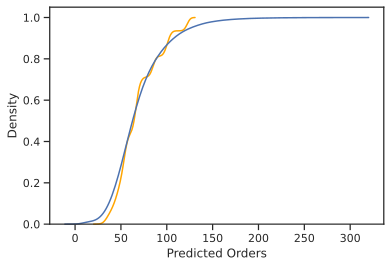

In [36]:
fix, ax = plt.subplots()
sns.kdeplot(res["Predicted Orders"], cumulative=True, color='orange', label='Predicted Orders')
sns.kdeplot(res["Real Orders"], cumulative=True, color='b', label='Real Orders')
plt.show()